# Modeling using neural network / deep learning-based models

In this notebook, we will cover how to implement a simple neural network for the modeling of heat capacity.

We will load, prepare featurize, and scale/normalize the input datasets the same way as we did in the pervious notebook. For more information about the individual steps, you can consult that notebook.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import OrderedDict

from CBFV import composition

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim


# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

## Featurizing and scaling data

Nothing new here---same steps as we've done in the previous notebook.

In [3]:
PATH = os.getcwd()
train_path = os.path.join(PATH, '../data/cp_train.csv')
val_path = os.path.join(PATH, '../data/cp_val.csv')
test_path = os.path.join(PATH, '../data/cp_test.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (3203, 3)
df_val DataFrame shape: (976, 3)
df_test DataFrame shape: (368, 3)


Here we do not sub-sample the datasets into smaller datasets like we did in the previous notebook.
Typically, the more data you have for neural networks, the better the networks will be able to train, and the better they will perform (as long as they are well-conditioned).

Additionally, the performance of `PyTorch` is very good for modern computers, especially if you have a modern CUDA-capable graphics processing unit (GPU) such as an Nvidia GPU to accelerate the computations.
Our dataset is small enough to fit into almost all modern computers or CUDA-capable GPUs.

In [4]:
rename_dict = {'Cp': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(df_train, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(df_val, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(df_test, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 3203/3203 [00:00<00:00, 17134.96it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 3203/3203 [00:00<00:00, 7141.97it/s] 


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 976/976 [00:00<00:00, 12533.80it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 976/976 [00:00<00:00, 11559.84it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 368/368 [00:00<00:00, 16708.93it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 368/368 [00:00<00:00, 7692.17it/s]


	Creating Pandas Objects...


In [5]:
X_train_unscaled.head()

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,mode_Melting_point_(K),mode_Boiling_Point_(K),mode_Density_(g/mL),mode_specific_heat_(J/g_K)_,mode_heat_of_fusion_(kJ/mol)_,mode_heat_of_vaporization_(kJ/mol)_,mode_thermal_conductivity_(W/(m_K))_,mode_heat_atomization(kJ/mol),mode_Cohesive_energy,T
0,34.0,69.6202,10.0,74.0,33.0,0.0,3.0,2.0,405.0,5.0,...,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62,1400.0
1,34.0,69.6202,10.0,74.0,33.0,0.0,3.0,2.0,405.0,5.0,...,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62,1300.0
2,34.0,69.6202,10.0,74.0,33.0,0.0,3.0,2.0,405.0,5.0,...,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62,1200.0
3,34.0,69.6202,10.0,74.0,33.0,0.0,3.0,2.0,405.0,5.0,...,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62,1100.0
4,34.0,69.6202,10.0,74.0,33.0,0.0,3.0,2.0,405.0,5.0,...,54.75,90.15,0.00143,0.92,0.22259,3.4099,0.02674,249.0,2.62,1000.0


In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

## Building a neural network

This is where you get to be the architect, and design your own neural network!

For sake of clarity (and to ensure that this tutorial runs on all the potatoes of this world), we will define a simple dense fully-connected neural network (which we will call `DenseNet`) as an example.

The input layer of `DenseNet` accepts input data in the dimension of each row of the input data, which is equal to the number of features in our CBFV featurization scheme.
In our particular example, when featurized using the `oliynyk` featurizer, the input dimension is 177 (it is the second dimension when you view `X_train.shape`).

The output layer dimension of `DenseNet` is 1, because we want to predict one value (heat capacity).

In addition, `DenseNet` can have one or more "hidden layers" that are attached between the input and output layers. These can be any arbitrary dimensions $>1$ you want to choose.

### Defining the network in PyTorch

In [7]:
class DenseNet(nn.Module):
    """
    This implements a dynamically-built dense fully-connected neural network
    with leaky ReLU activation and optional dropout.

    Parameters
    ----------
    input_dims: int
        Number of input features (required).
    hidden_dims: list of ints
        Number of hidden features, where each integer represents the number of
        hidden features in each subsequent hidden linear layer (optional,
        default=[64, 32]).
    output_dims: int
        Number of output features (optional, default=1).
    dropout: float
        the dropout value (optional, default=0.0).
    """
    def __init__(self,
                 input_dims,
                 hidden_dims=[64, 32],
                 output_dims=1,
                 dropout=0.0):
        super().__init__()

        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims

        self.dropout = dropout
        
        # Build a sub-block of linear networks
        def fc_block(in_dim, out_dim, *args, **kwargs):
            return nn.Sequential(
                nn.Linear(in_dim, out_dim, *args, **kwargs),
                nn.Dropout(p=self.dropout),
                nn.LeakyReLU()
                )

        # Build overall network architecture
        self.network = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(input_dims, self.hidden_dims[0]),
                    nn.Dropout(p=self.dropout),
                    nn.LeakyReLU())
                ]
            )

        hidden_layer_sizes = zip(self.hidden_dims[:-1], self.hidden_dims[1:])
        self.network.extend([
            fc_block(in_dim, out_dim) for in_dim, out_dim
            in hidden_layer_sizes]
            )

        self.network.extend([
            nn.Linear(hidden_dims[-1], output_dims)]
            )


    def forward(self, x):
        """
        Forward pass of the DenseNet model.

        Parameters
        ----------
        x: torch.Tensor
            A representation of the chemical compounds in the shape
            (n_compounds, n_feats).

        Returns
        -------
        y: torch.Tensor
            The element property prediction with the shape 1.
        """
        for i, subnet in enumerate(self.network):
            x = subnet(x)
            
        y = x

        return y

### Specifying the compute device for calculations

Before we run the neural network, we can first check if your machine has a CUDA-capable device.
CUDA is a specific set of application instructions (application programming interfaces, APIs) that PyTorch can use to accelerate some of the calculations performed in neural networks.

Generally, a relatively recent GPU from Nvidia will support CUDA capabilities, and can be used to accelerate neural network computations in PyTorch.

In case you do not have a CUDA-capable device, PyTorch will fall back to using the CPU. Depending on the complexity of your model, training and predicting using a CPU can take significantly longer than using a CUDA-capable GPU.

Consult the [PyTorch](https://pytorch.org/docs/stable/torch.html) and [CUDA](https://docs.nvidia.com/cuda/) documentation for more information.

In [8]:
CUDA_available = torch.cuda.is_available()
print(f'CUDA is available: {CUDA_available}')

if CUDA_available:
    compute_device = torch.device('cuda')
else:
    compute_device = torch.device('cpu')
    
print(f'Compute device for PyTorch: {compute_device}')

CUDA is available: False
Compute device for PyTorch: cpu


### Defining the data loader and dataset structure

Here we define a dataloader class specific for loading CBFV-type datasets.

We also define the CBFV dataset class that tells PyTorch how our dataset is structured, and how to grab individual data samples from our dataset.

In [9]:
class CBFVDataLoader():
    """
    Parameters
    ----------
    train_data: np.ndarray or pd.DataFrame or pd.Series
        name of csv file containing cif and properties
    val_data: np.ndarray or pd.DataFrame or pd.Series
        name of csv file containing cif and properties
    test_data: np.ndarray or pd.DataFrame or pd.Series
        name of csv file containing cif and properties
    batch_size: float, optional (default=64)
        Step size for the Gaussian filter
    random_state: int, optional (default=42)
        Random seed for sampling the dataset. Only used if validation data is
        not given.
    shuffle: bool, optional (default=True)
        Whether to shuffle the datasets or not
    """
    def __init__(self, train_data, val_data, test_data,
                 batch_size=64, num_workers=1, random_state=42,
                 shuffle=True, pin_memory=True):

        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

        self.shuffle = shuffle
        self.random_state = random_state


    def get_data_loaders(self, batch_size=1):
        '''
        Input the dataset, get train test split
        '''
        train_dataset = CBFVDataset(self.train_data)
        val_dataset = CBFVDataset(self.val_data)
        test_dataset = CBFVDataset(self.test_data)

        train_loader = DataLoader(train_dataset,
                                  batch_size=self.batch_size,
                                  pin_memory=self.pin_memory,
                                  shuffle=self.shuffle)

        val_loader = DataLoader(val_dataset,
                                batch_size=self.batch_size,
                                pin_memory=self.pin_memory,
                                shuffle=self.shuffle)

        test_loader = DataLoader(test_dataset,
                                 batch_size=self.batch_size,
                                 pin_memory=self.pin_memory,
                                 shuffle=False)

        return train_loader, val_loader, test_loader


class CBFVDataset(Dataset):
    """
    Get X and y from CBFV-based dataset.
    """
    def __init__(self, dataset):
        self.data = dataset

        self.X = np.array(self.data[0])
        self.y = np.array(self.data[1])
        self.shape = [(self.X.shape), (self.y.shape)]

    def __str__(self):
        string = f'CBFVDataset with X.shape {self.X.shape}'
        return string

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = self.X[[idx], :]
        y = self.y[idx]

        X = torch.as_tensor(X)
        y = torch.as_tensor(np.array(y))

        return (X, y)

Here we choose a batch size for loading data, and initialize the DataLoader for loading the featurized input data.

We also get the data loaders corresponding to the train, validation, and test datasets.

In [10]:
train_data = (X_train, y_train)
val_data = (X_val, y_val)
test_data = (X_test, y_test)

# Instantiate the DataLoader
batch_size = 128
data_loaders = CBFVDataLoader(train_data, val_data, test_data, batch_size=batch_size)
train_loader, val_loader, test_loader = data_loaders.get_data_loaders()

### Instantiating a `DenseNet` model

Now, we can instantiate... an instance of the `DenseNet` model.

In [11]:
# Get input dimension size from the dataset
example_data = train_loader.dataset.data[0]
input_dims = example_data.shape[-1]

# Instantiate the model
model = DenseNet(input_dims, hidden_dims=[16], dropout=0.0)
print(model)

DenseNet(
  (network): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=309, out_features=16, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=16, out_features=1, bias=True)
  )
)


### Defining the loss criterion & optimizer

Here, we see the model and its individual layers and components printed nicely.

We then instantiate and initialize the loss criterion and optimizer.

Note, there are many choices of loss criteria and optimizers that are provided by PyTorch, each with their benefits and limitations, and a myriad of parameters.
Consult the PyTorch documentation for further details.

In [12]:
# Initialize the loss criterion
criterion = nn.L1Loss()
print('Loss criterion: ')
print(criterion)

# Initialize the optimzer
optim_lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=optim_lr)
print('\nOptimizer: ')
print(optimizer)

Loss criterion: 
L1Loss()

Optimizer: 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


### Moving the model to the compute device

Then, we can move the model and loss criterion computation to the compute device.

If you have a GPU, this will trasnfer and attach the required resources to the GPU. If you have a CPU, then everything will remain on the CPU.

In [13]:
# Move the model and criterion to the compute device
model = model.to(compute_device)
criterion = criterion.to(compute_device)

### Defining some additional helper functions

We define some scaler functions and helper functions to evaluate and visualize model results.

In [14]:
class Scaler():
    def __init__(self, data):
        self.data = torch.as_tensor(data)
        self.mean = torch.mean(self.data)
        self.std = torch.std(self.data)

    def scale(self, data):
        data = torch.as_tensor(data)
        data_scaled = (data - self.mean) / self.std
        return data_scaled

    def unscale(self, data_scaled):
        # Ensure tensor
        data_scaled = torch.as_tensor(data_scaled, dtype=torch.float32)

        # Match device of incoming tensor (CPU or GPU)
        device = data_scaled.device
        std = self.std.to(device)
        mean = self.mean.to(device)

        data = torch.exp(data_scaled * std + mean)
        return data

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']


class MeanLogNormScaler():
    def __init__(self, data):
        self.data = torch.as_tensor(data)
        self.logdata = torch.log(self.data)
        self.mean = torch.mean(self.logdata)
        self.std = torch.std(self.logdata)

    def scale(self, data):
        data = torch.as_tensor(data)
        data_scaled = (torch.log(data) - self.mean) / self.std
        return data_scaled

    def unscale(self, data_scaled):
        data_scaled = torch.as_tensor(data_scaled, dtype=torch.float32)
        device = data_scaled.device
        std = self.std.to(device)
        mean = self.mean.to(device)
        return torch.exp(data_scaled * std + mean)


    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

In [15]:
def predict(model, data_loader):
    target_list = []
    pred_list = []

    model.eval()
    with torch.no_grad():
        for i, data_output in enumerate(data_loader):
            X, y_act = data_output
            X = X.to(compute_device,
                     dtype=data_type,
                     non_blocking=True)
            y_act = y_act.cpu().flatten().tolist()
            y_pred = model.forward(X).cpu().flatten().tolist()

            # Unscale target values
            y_pred = target_scaler.unscale(y_pred).tolist()

            targets = y_act
            predictions = y_pred
            target_list.extend(targets)
            pred_list.extend(predictions)
    model.train()

    return target_list, pred_list


def evaluate(target, pred):
    r2 = r2_score(target, pred)
    mae = mean_absolute_error(target, pred)
    rmse = mean_squared_error(target, pred)
    output = (r2, mae, rmse)
    return output


def print_scores(scores, label=''):
    r2, mae, rmse = scores
    print(f'{label} r2: {r2:0.4f}')
    print(f'{label} mae: {mae:0.4f}')
    print(f'{label} rmse: {rmse:0.4f}')
    return scores


def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')
    
    return plot

We scale the target variables.

In [16]:
y_train = [data[1].numpy().tolist() for data in train_loader]
y_train = [item for sublist in y_train for item in sublist]

y_train = train_loader.dataset.y

target_scaler = MeanLogNormScaler(y_train)

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### Training the neural network

And finally, we train the neural network.

This is the training procedure for the neural network:
* for each `epoch`: 
  * iterate through the train dataset using `train_loader`:
    * scale the target data
    * transfer input (`X`) and target (`y`) data to compute device
    * reset the optimizer's gradient to zero
    * compute the output of the model (forward pass)
    * calculate the loss of the model (between the predicted and true target values)
    * propagate the loss backwards through the model (backpropagation)
    * update the weights throughout the model
  * if `epoch == print_every`:
    * print the current epoch (to keep track of training progress)
  * if `epoch == plot_every`:
    * evaluate the model on the validation dataset using `val_loader`
    * plot predicted vs. actual value plots
    * print the train and val $r^2$, $\textrm{MAE}$ and $\textrm{RMSE}$ scores of the model

Note: training this network may take up to tens of minutes, depending on your hardware configuration and whether or not you have a CUDA-capable device.

epoch: 0
train r2: -0.0285
train mae: 46.3325
train rmse: 3773.4100


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


val r2: -0.0137
val mae: 54.4284
val rmse: 6457.5260


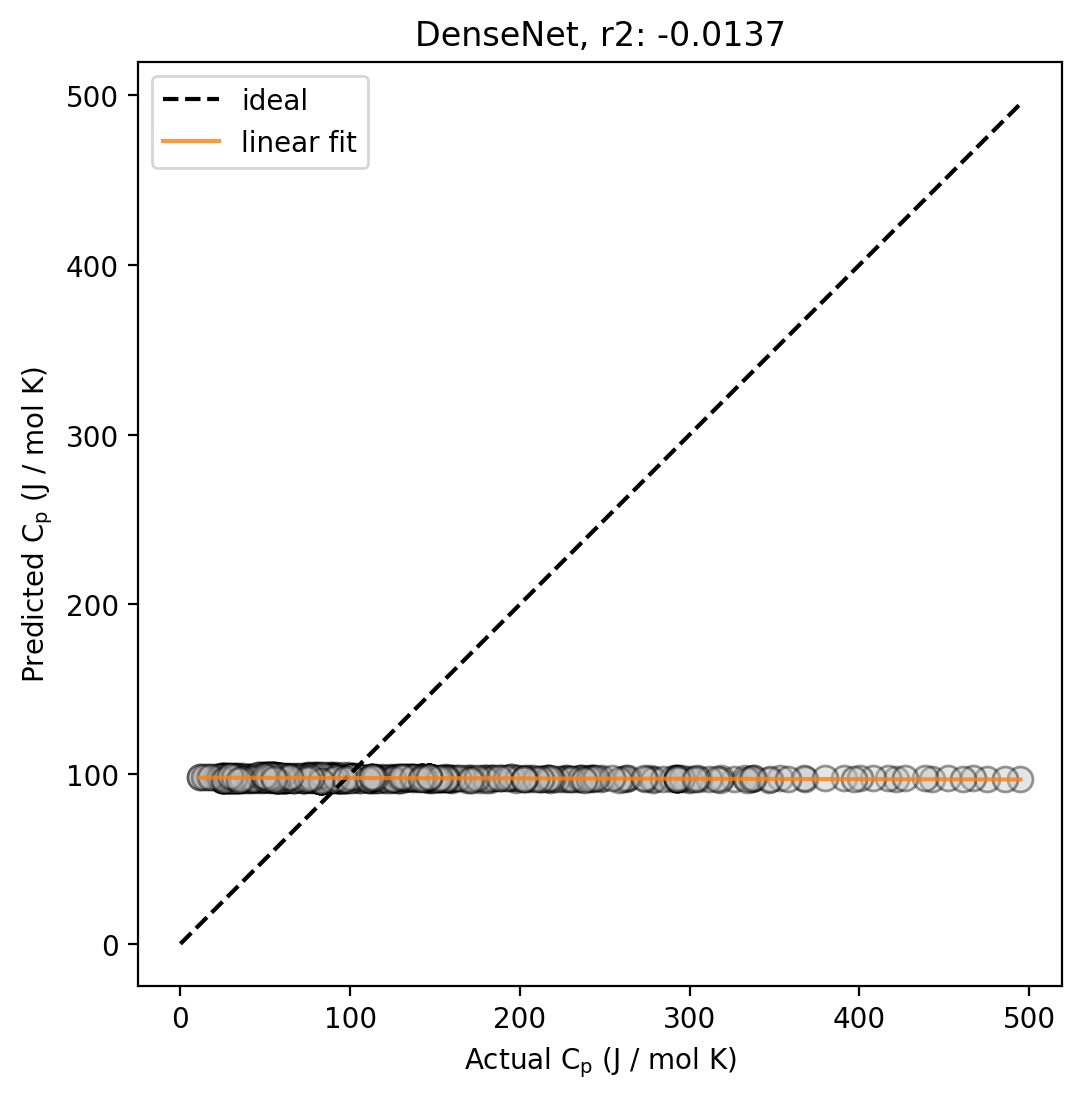

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 20
epoch: 40
train r2: 0.9783
train mae: 4.9851
train rmse: 79.5083
val r2: 0.9043
val mae: 14.2423
val rmse: 609.5548


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


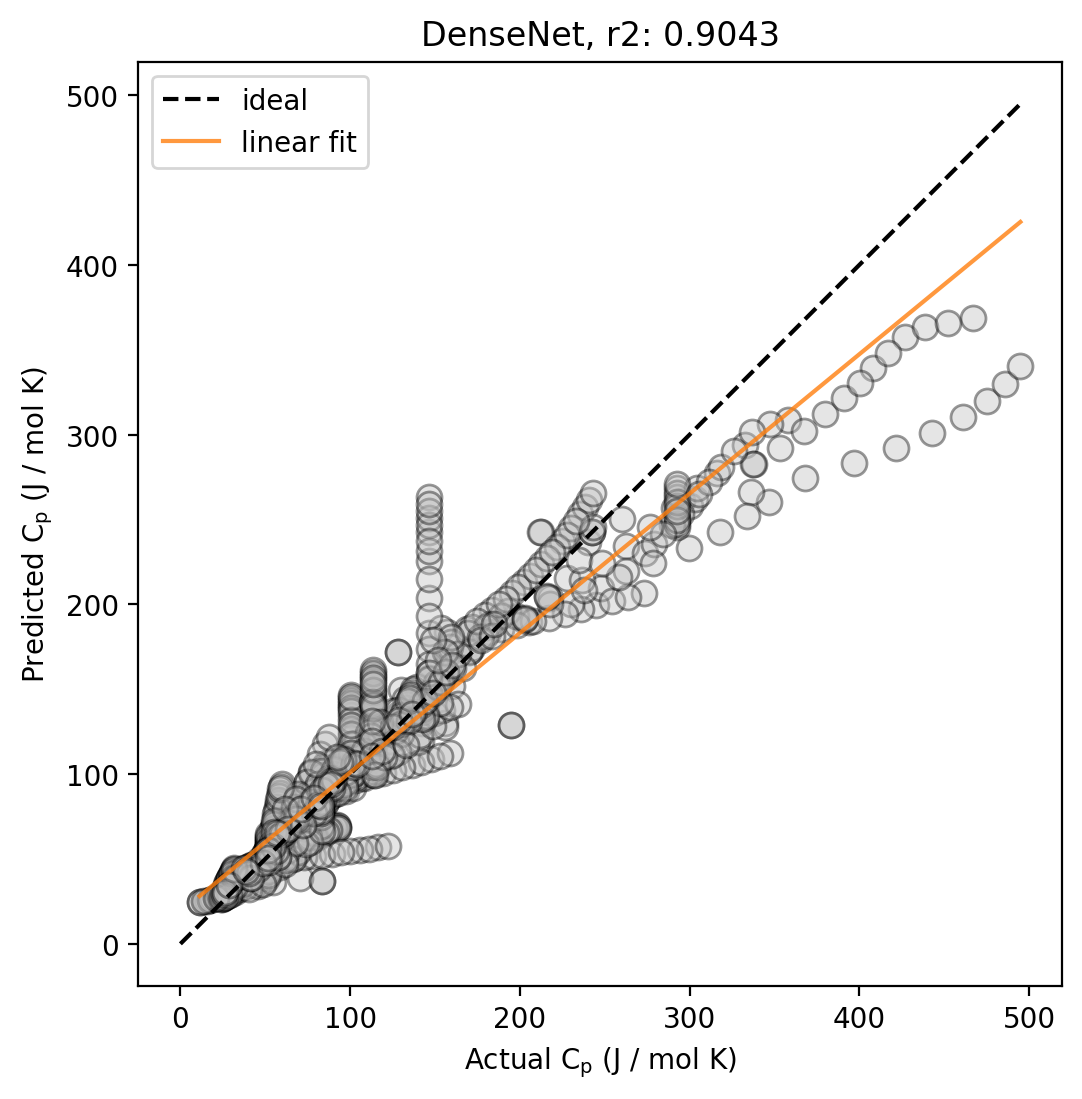

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 60
epoch: 80
epoch: 100
train r2: 0.9847
train mae: 3.9178
train rmse: 56.2009
val r2: 0.9011
val mae: 14.0859
val rmse: 630.0456


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


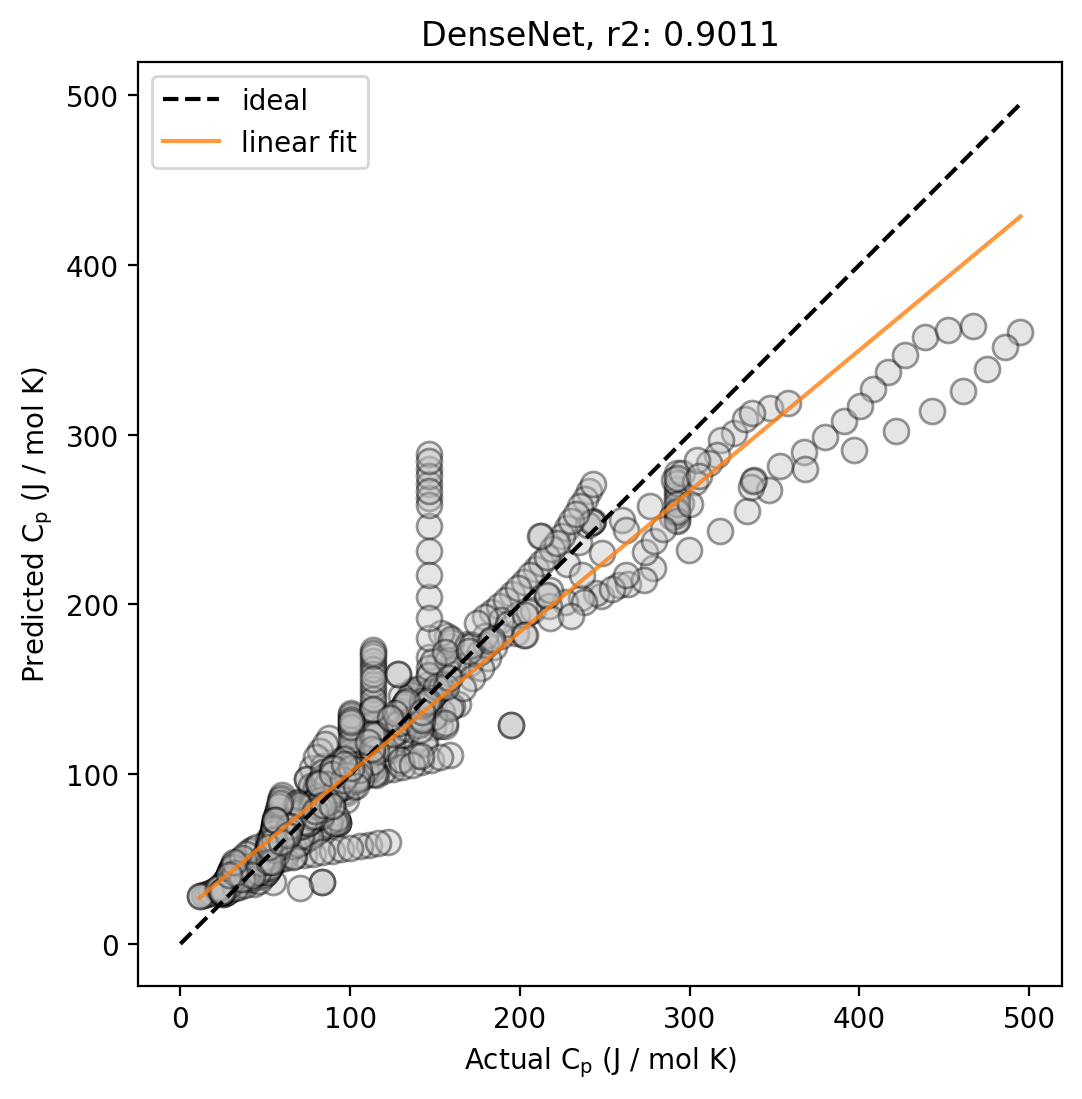

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 120
epoch: 140
train r2: 0.9847
train mae: 3.9168
train rmse: 56.2404
val r2: 0.9126
val mae: 13.9093
val rmse: 556.6181


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


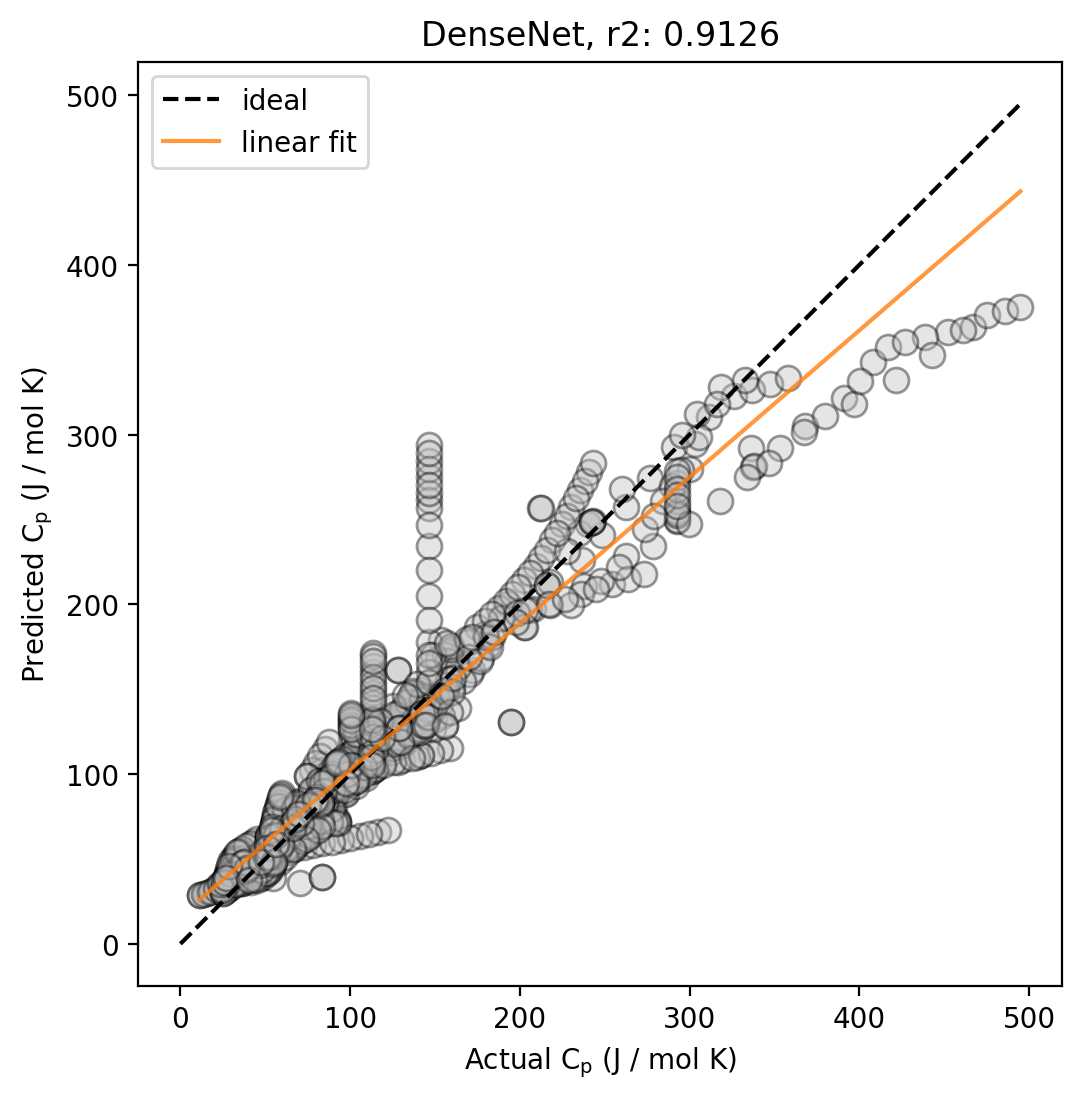

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 160
epoch: 180
epoch: 200
train r2: 0.9853
train mae: 3.8384
train rmse: 53.9458
val r2: 0.8937
val mae: 14.8017
val rmse: 677.3795


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


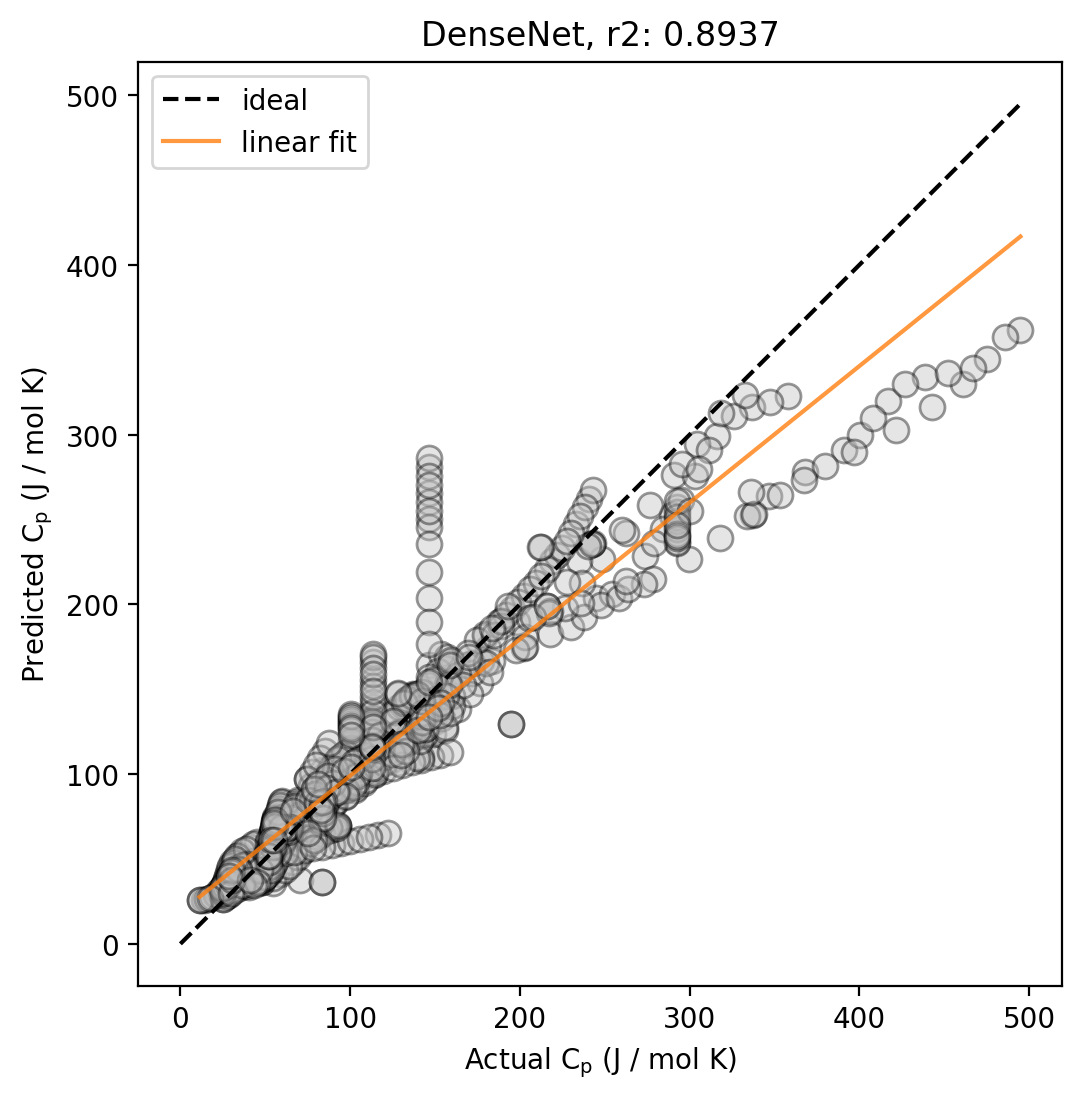

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 220
epoch: 240
train r2: 0.9876
train mae: 3.4107
train rmse: 45.6259
val r2: 0.9060
val mae: 14.4627
val rmse: 599.0181


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


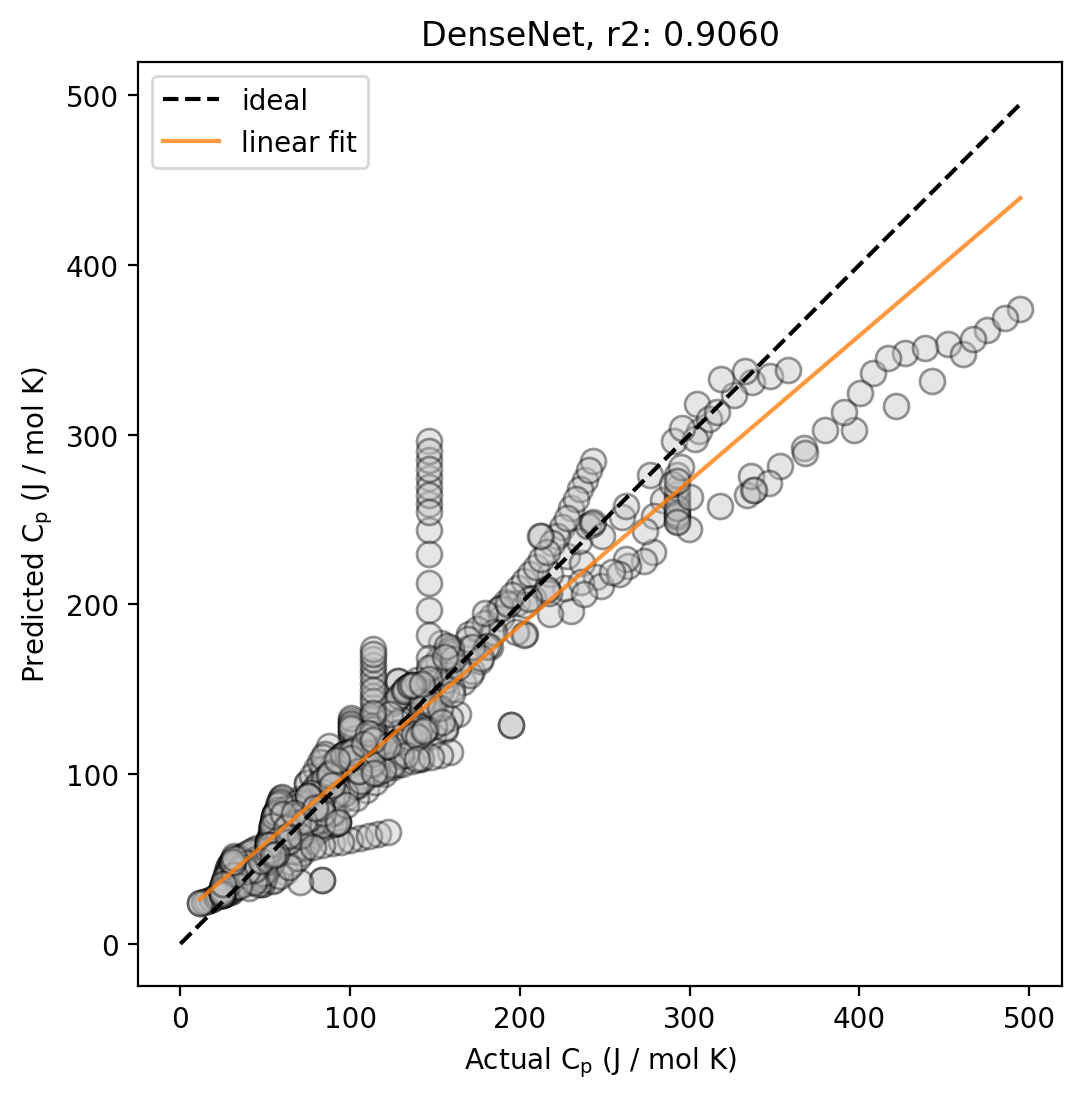

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 260
epoch: 280
epoch: 300
train r2: 0.9885
train mae: 3.2507
train rmse: 42.1964
val r2: 0.9029
val mae: 14.6021
val rmse: 618.4490


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


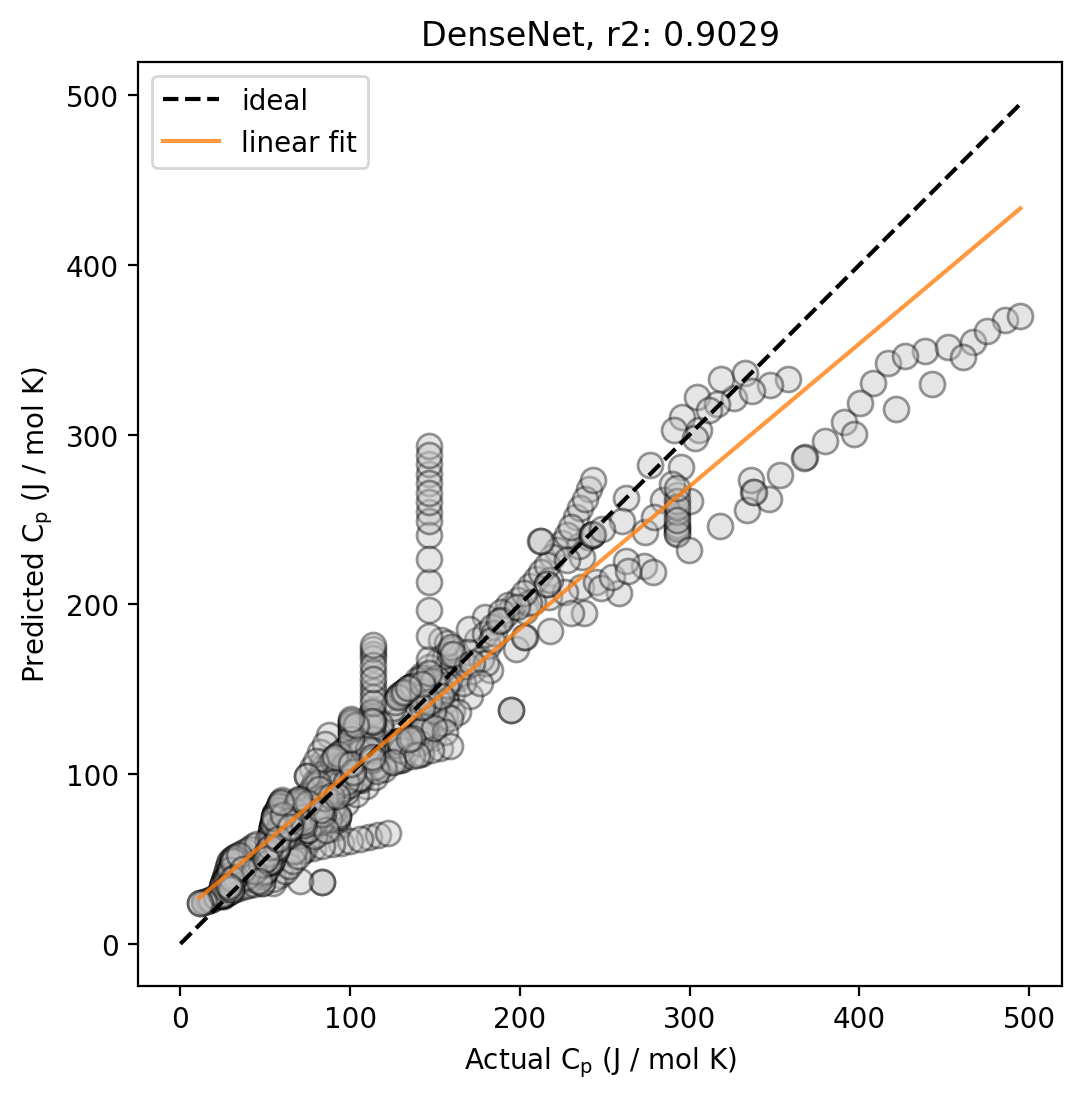

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 320
epoch: 340
train r2: 0.9882
train mae: 3.1654
train rmse: 43.3726
val r2: 0.8965
val mae: 15.0494
val rmse: 659.1810


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


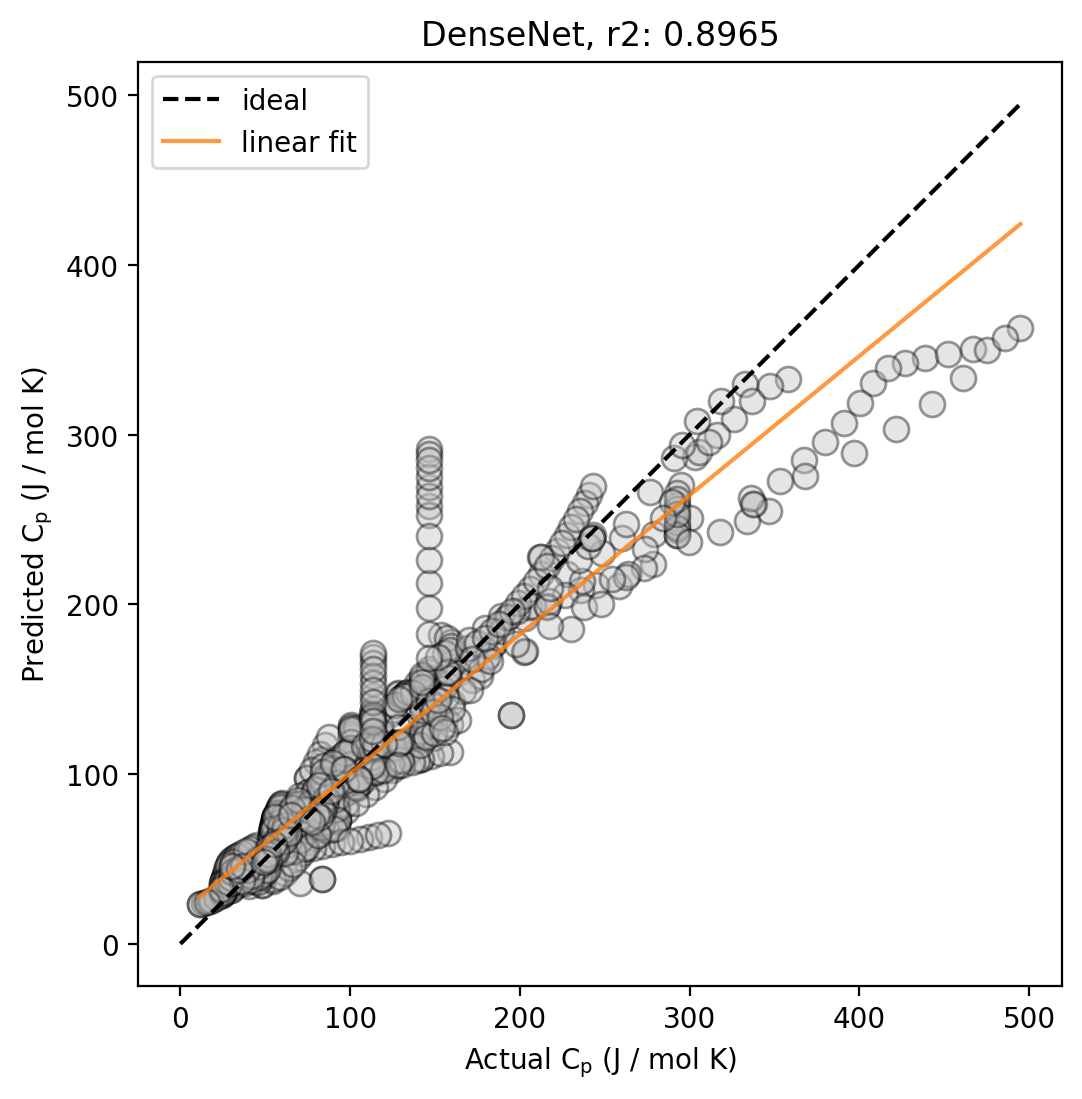

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 360
epoch: 380
epoch: 400
train r2: 0.9894
train mae: 2.8715
train rmse: 38.7458
val r2: 0.9036
val mae: 14.5460
val rmse: 614.3962


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


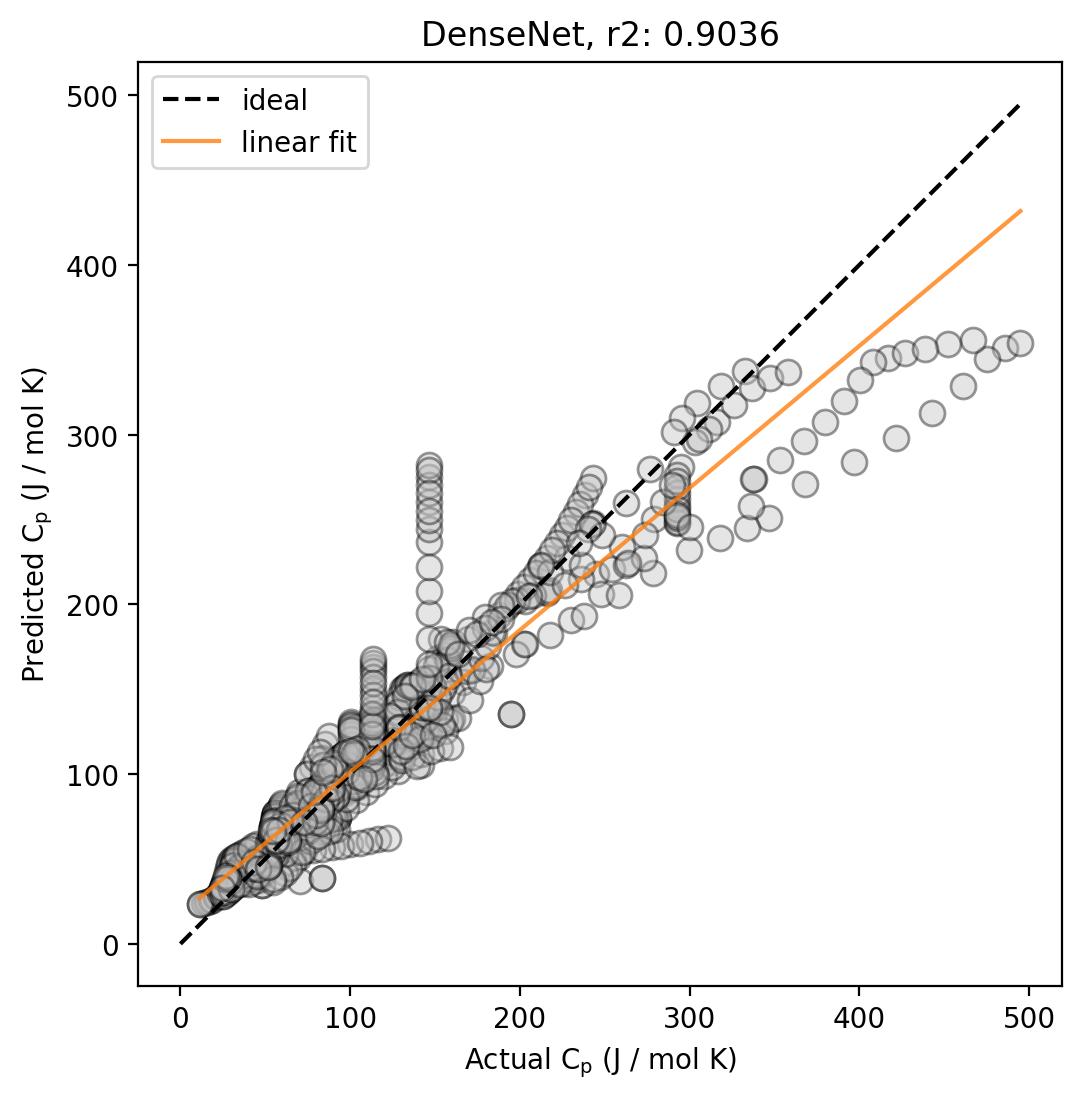

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 420
epoch: 440
train r2: 0.9880
train mae: 3.4581
train rmse: 43.9479
val r2: 0.8907
val mae: 15.7323
val rmse: 696.3435


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


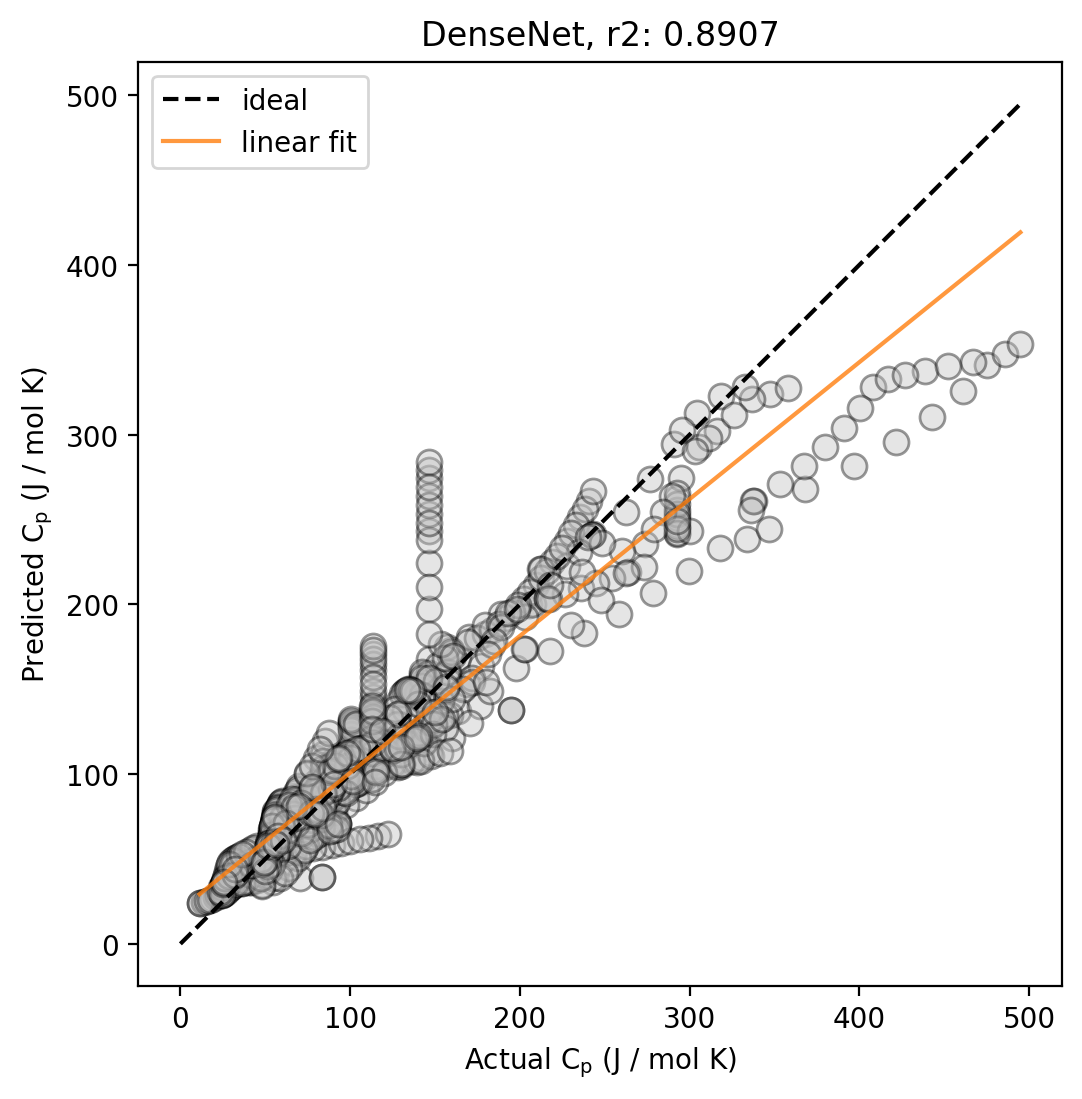

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch: 460
epoch: 480
epoch: 499


In [17]:
data_type = torch.float
epochs = 500

print_every = 20
plot_every = 50

for epoch in range(epochs):
    if epoch % print_every == 0 or epoch == epochs - 1:
        print(f'epoch: {epoch}')
    if epoch % plot_every == 0:        
        target_train, pred_train = predict(model, train_loader)
        train_scores = evaluate(target_train, pred_train)
        print_scores(train_scores, label='train')
        
        target_val, pred_val = predict(model, val_loader)
        val_scores = evaluate(target_val, pred_val)
        print_scores(val_scores, label='val')
        plot_pred_act(target_val, pred_val, model, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')
        plt.show()
        
    for i, data_output in enumerate(train_loader):
        X, y = data_output
        y = target_scaler.scale(y)
        
        X = X.to(compute_device,
                 dtype=data_type,
                 non_blocking=True)
        y = y.to(compute_device,
                 dtype=data_type,
                 non_blocking=True)
        
        optimizer.zero_grad()
        output = model.forward(X).flatten()
        loss = criterion(output.view(-1), y.view(-1))
        loss.backward()
        optimizer.step()

Now, with our trained neural network, we can evaluate the performance of the model (at the end of the training phase) on the validation dataset.

val r2: 0.8988
val mae: 14.4554
val rmse: 644.9291


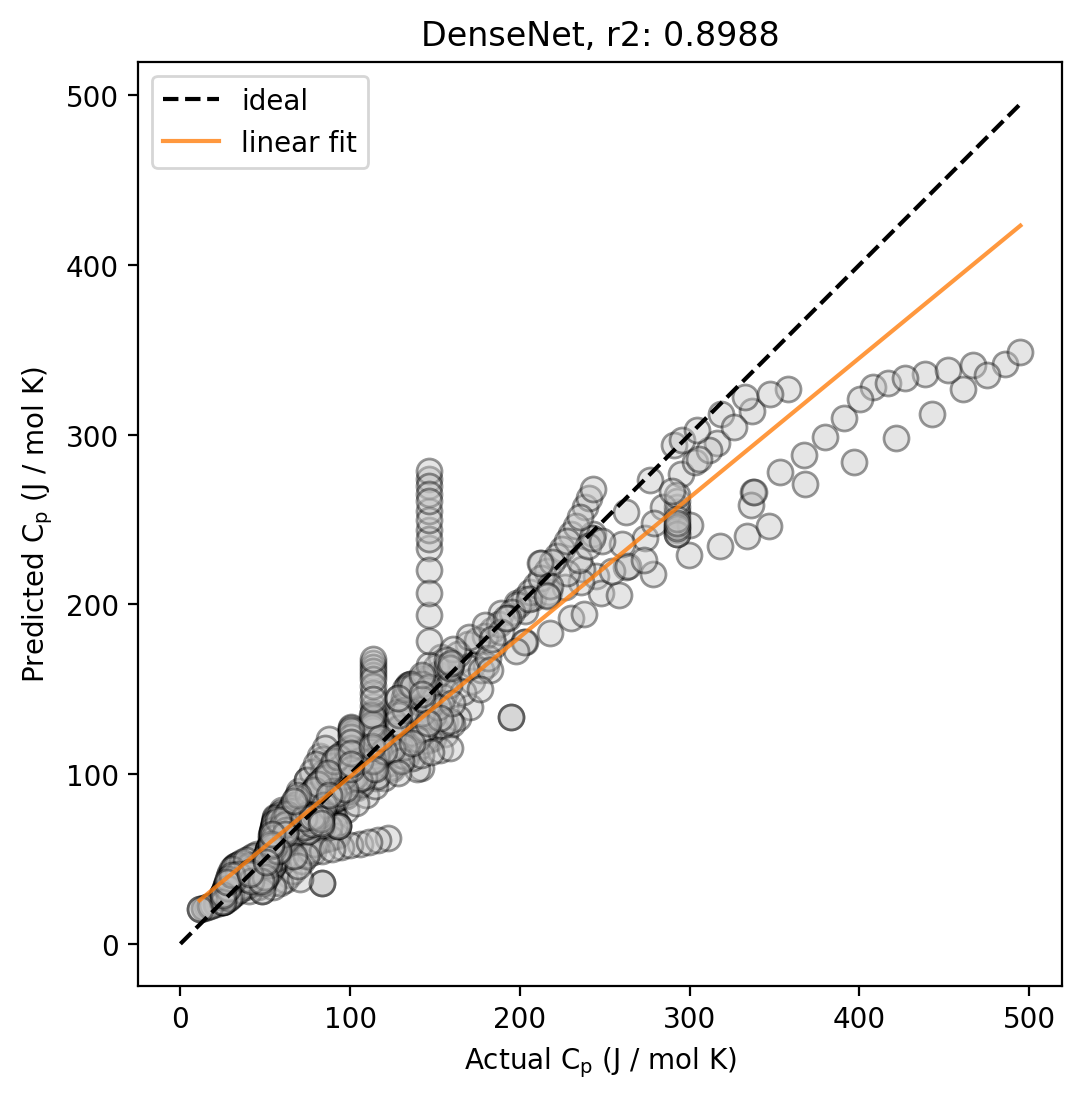

In [18]:
target_val, pred_val = predict(model, val_loader)
scores = evaluate(target_val, pred_val)

print_scores(scores, label='val')

plot = plot_pred_act(target_val, pred_val, model, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

## Keeping track of training progress -- avoid overfitting

Note, you can keep track of the training progress by saving the train and validation metrics such as $r^2$ and MAE at every epoch.
Then, you can plot so-called "loss curves" that show the loss of the model vs. epoch throughout the training process.
This gives you additional insight into your model training process, and helps you diagnose issues such as overfitting, improper model/optimizer/loss parameters, and so on.

Once you start tracking these performance metrics during your training loop, you can also implement more advanced training techniques such as "early stopping".
In early stopping, you observe the performance metrics (such as validation $r^2$ or MAE) over the training epochs, and you stop the training process if you observe that the metrics are not improving any more (meaning your model is fully trained), or if the metrics are increasing again after reaching a minimum (meaning your model is overfitting the training set).

## Evaluating model performance on test dataset

And finally evaluate the performance on the test dataset.
**Remember:** you should only do this *once!*

c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


test r2: 0.8834
test mae: 14.9224
test rmse: 710.3556


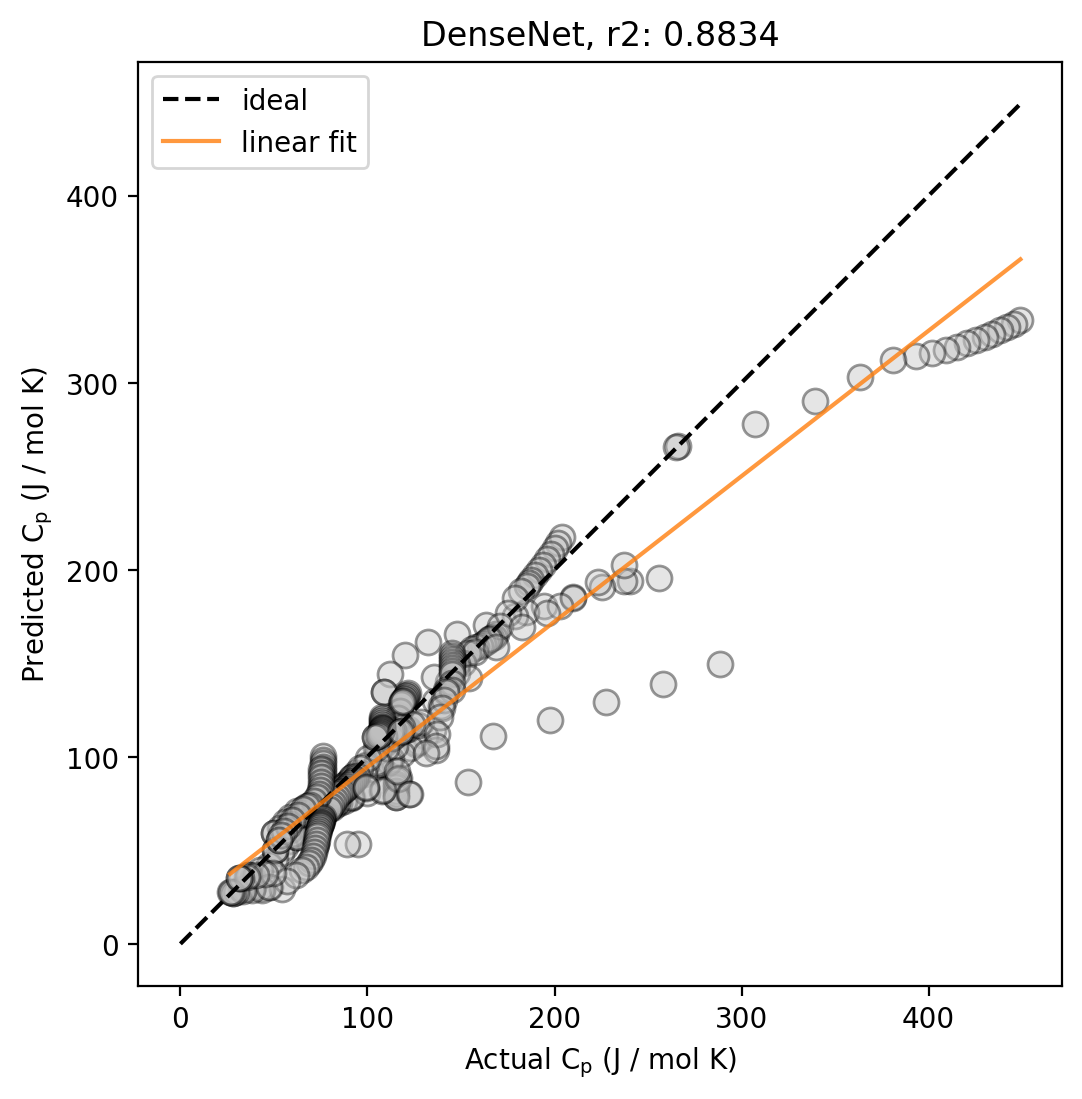

In [19]:
target_test, pred_test = predict(model, test_loader)
scores = evaluate(target_test, pred_test)

print_scores(scores, label='test')

plot = plot_pred_act(target_test, pred_test, model, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

# Exporting PyTorch models

Now that we've got a (reasonably well-performing) model, we can export the weights and biases from the model to what is referred to as a "checkpoint" file.

The advantages of exporting your model to a checkpoint file are manifold.
For example, when you want to re-use the model again later (to make further predictions, or even to continue training), you don't have to train the model from scratch again.
For our current `DenseNet` model, this may not seem like a big deal, since it trains within minutes.
But once you start moving on to larger and larger models, model training time can reach hours, days---even weeks!

Another advantage is that you can greatly enhance the reproducibility of your work.
If you export your models, other researchers can then recreate your model architecture on their system, then load your weights into the model to get exactly the model you trained.
This allows them to use your model as-is, and enables them to reproduce your work---an important step if they are to judge the merit of your work.

With that said, we will now use PyTorch's built-in methods to export (1) our `DenseNet` model, and (2) our `target_scaler` (we need to export our `target_scaler` object as well, because we need to use it to unscale the model predictions to get back the true prediction values.

## Saving the model + target scaler

In [20]:
save_dict = {'weights': model.state_dict(),
             'scaler_state': target_scaler.state_dict()}
print(save_dict)

{'weights': OrderedDict([('network.0.0.weight', tensor([[  0.3411,   0.3336,   0.2864,  ...,   0.4736,   0.2121,   5.6152],
        [ -1.5008,  -1.4378,  -1.4765,  ...,  -0.7317,  -0.6769,   5.6235],
        [ -0.3321,  -0.2354,   0.1433,  ...,   0.0363,  -0.4299,   4.6606],
        ...,
        [ -0.7469,  -0.7096,  -0.3872,  ...,   0.0290,  -0.3470, -10.1465],
        [ -1.2875,  -1.2122,  -0.6774,  ...,   0.9819,   0.0252, -12.4491],
        [  0.5998,   0.6096,   0.7285,  ...,   0.3975,  -0.1774,  -0.4956]])), ('network.0.0.bias', tensor([-0.7008, -0.1493, -1.1053, -1.5568, -0.3546, -0.5482, -0.0573, -0.4408,
        -0.9264,  0.2547, -0.2328,  0.2074, -0.5771, -0.1676, -0.1375,  0.3273])), ('network.1.weight', tensor([[ 0.1005, -0.1621,  0.1934,  0.1476,  0.1578, -0.1187, -0.1500,  0.0505,
         -0.7599, -0.1020, -0.1266,  0.1304,  0.1378, -0.1453, -0.4461,  0.1388]])), ('network.1.bias', tensor([0.1299]))]), 'scaler_state': {'mean': tensor(4.5148, dtype=torch.float64), 'std': 

In [21]:
pth_path = ('model_checkpoint.pth') # .pth is commonly used as the file extension
torch.save(save_dict, pth_path)

Navigate to your notebooks directory. You should now find a file named 'model_checkpoint.pth'.
Since the `DenseNet` model is small, the checkpoint file weighs in relatively lightly at 13KB.
Bigger models will have more weights & biases, and will require more storage space for the checkpoint file.

## Loading the model + target scaler

Of course, if you provide the facilities to **save** a model, you should also provide facilities to **load** them and to recreate your model back.

Thankfully, PyTorch makes this also easy.

In [22]:
# First, clear the variables for model and target_scaler.
# We want to start with a clean slate.
model = None
target_scaler = None
del model
del target_scaler

We start by recreating the `DenseNet` model and the `target_scaler` that we originally built. This model will be initialized with random weights & biases, which we will then overload (overwrite) afterwards with the values from the checkpoint file.

Make sure that you create the same model and `target_scaler` here as the ones you saved the checkpoint file from. Otherwise you will not be able to load the checkpoint file, or it will produce unexpected results.

In [23]:
# Instantiate the model.
# The model will be randomly initialized, but we will overwrite
# all weights and biases when we load the checkpoint.
model = DenseNet(input_dims, hidden_dims=[16], dropout=0.0)
model = model.to(compute_device)
print(model)

# Instantiate the target_scaler.
# We initialize this target_scaler with a vector of zeros,
# but we will overwrite its internal parameters
# when we load the checkpoint.
target_scaler = MeanLogNormScaler(torch.zeros(42))

DenseNet(
  (network): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=309, out_features=16, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [24]:
# Load the checkpoint and map it to the compute device
pth_path = ('model_checkpoint.pth')
checkpoint = torch.load(pth_path, map_location=compute_device)

# Load the state dictionaries back into the model and target_scaler
model.load_state_dict(checkpoint['weights'])
target_scaler.load_state_dict(checkpoint['scaler_state'])

## Checking the loaded model

In [25]:
import inspect
print(inspect.getsource(target_scaler.unscale))


    def unscale(self, data_scaled):
        data_scaled = torch.as_tensor(data_scaled, dtype=torch.float32)
        device = data_scaled.device
        std = self.std.to(device)
        mean = self.mean.to(device)
        return torch.exp(data_scaled * std + mean)



test r2: 0.8834
test mae: 14.9224
test rmse: 710.3556


c:\uv_venvs\best_practices\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


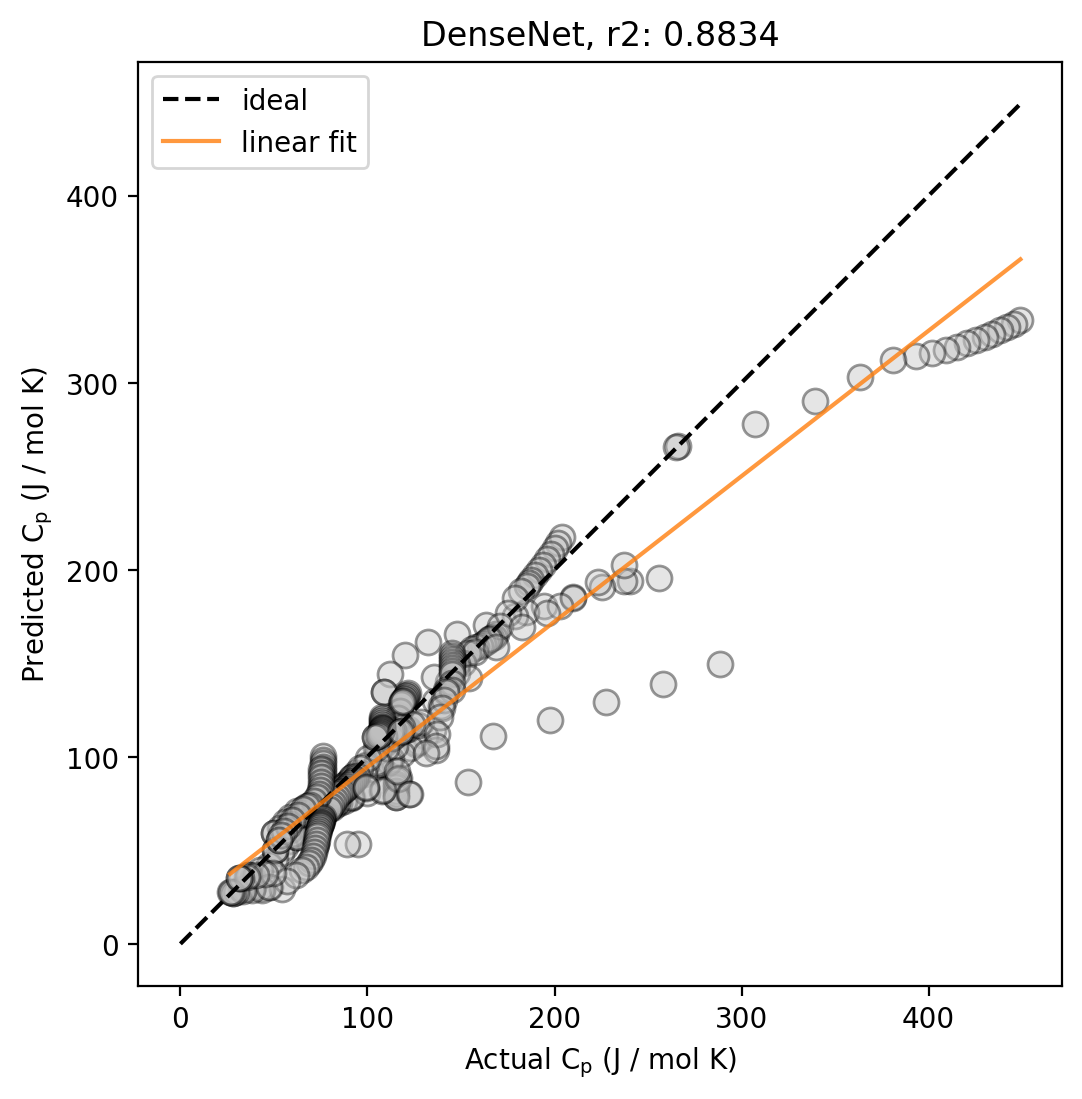

In [26]:
target_test, pred_test = predict(model, test_loader)
scores = evaluate(target_test, pred_test)

print_scores(scores, label='test')

plot = plot_pred_act(target_test, pred_test, model, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')

Hooray!